In [1]:
# this notebook will fit an n-th degree plonomial surface to steering data
# import modules
import numpy as np
from numpy.polynomial.polynomial import polyval2d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import lmfit as lm

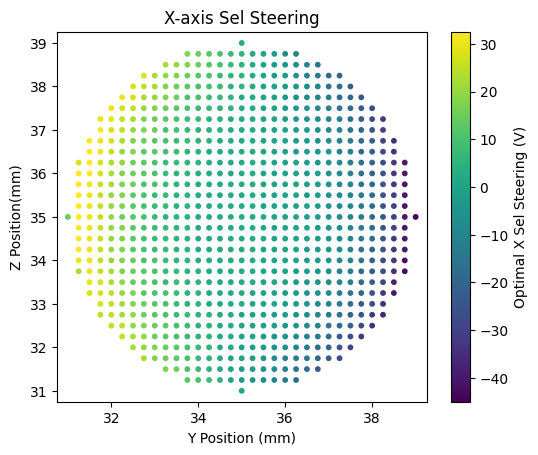

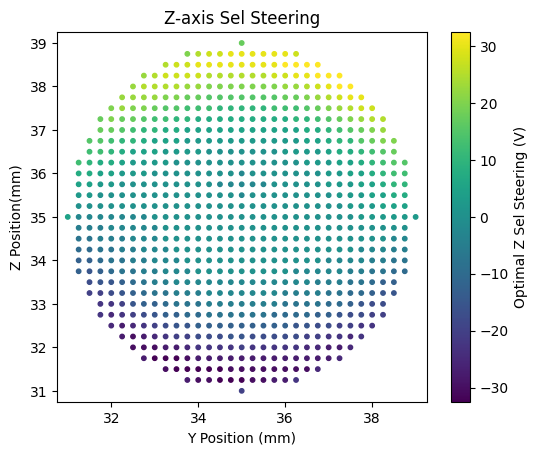

In [2]:
# import data from processed file
data = np.genfromtxt("ExtractionSteering2DScan_data.csv", delimiter=",")
ypos = data[1:, 0]
zpos = data[1:, 1]
vsteerx = data[1:, 3]
vsteerz = data[1:, 4]
p_step = ypos[1] - ypos[0]

# plot the data in 2d
plt.figure('BestSelXSteering')
plt.scatter(ypos,zpos,c=vsteerx, s=10)
plt.xlabel('Y Position (mm)')
plt.ylabel('Z Position(mm)')
plt.xlim(min(ypos)-p_step, max(ypos)+p_step)
plt.ylim(min(zpos)-p_step, max(zpos)+p_step)
plt.colorbar(label="Optimal X Sel Steering (V)")
plt.title('X-axis Sel Steering')
plt.gca().set_aspect('equal')

plt.figure('BestSelZSteering')
plt.scatter(ypos,zpos,c=vsteerz, s=10)
plt.xlabel('Y Position (mm)')
plt.ylabel('Z Position(mm)')
plt.xlim(min(ypos)-p_step, max(ypos)+p_step)
plt.ylim(min(zpos)-p_step, max(zpos)+p_step)
plt.colorbar(label="Optimal Z Sel Steering (V)")
plt.title('Z-axis Sel Steering')
plt.gca().set_aspect('equal')

In [3]:
# use numpy to make polynomial surface

# generate all names for coefficients
order = 3 
dy, dz = (order,order)
coeff_names = []
for i in range(dy+1):
    for j in range(dz+1):
        coeff_names.append('c'+str(i)+str(j))
        exec('c'+str(i)+str(j)+' = i*10+j')

coeff_names2d = np.reshape(coeff_names,(dy+1,dz+1))
#print(coeff_names)

exec('def polysurf(y, z, '+', '.join(coeff_names)+'):\n\tc = np.empty((dy+1,dz+1))\n\tfor i in range(np.shape(c)[0]):\n\t\tfor j in range(np.shape(c)[1]):\n\t\t\texec("c[i,j] = "+coeff_names2d[i,j])\n\treturn polyval2d(y, z, c)')

In [4]:
model = lm.Model(polysurf, independent_vars=['y','z'], nan_policy= 'omit')
params = model.make_params()
for p in model.param_names:
    params[p].value = 1
#params.pretty_print(columns=['value'])

In [5]:
xsteer_result = model.fit(vsteerx, y=ypos, z=zpos, params=params)
xsteer_file = open('SEL_X_Steering_EquationParameters.csv', 'w', encoding="utf-8")
xsteer_file.write(xsteer_result.fit_report(show_correl=False))
xsteer_file.write('\n[[Model Equation]]\n\u03A3_i\u03A3_j c_i,j * ypos^i * zpos^j')
xsteer_file.close()
print(xsteer_result.params.pretty_print(columns=['value', 'stderr']))

Name     Value   Stderr
c00  2.456e+06 2.954e+06
c01  -2.169e+05 2.536e+05
c02      6434     7249
c03    -63.48    69.03
c10  -2.115e+05 2.536e+05
c11  1.872e+04 2.177e+04
c12    -556.8    622.3
c13     5.506    5.926
c20      6093     7249
c21      -540    622.3
c22     16.08    17.79
c23   -0.1592   0.1694
c30     -58.8    69.03
c31     5.209    5.926
c32   -0.1551   0.1694
c33  0.001535 0.001613
None


In [16]:
%matplotlib notebook

# Generate meshgrid for plotting
num_points = 1000
y_range = np.linspace(min(ypos), max(ypos), num_points)
z_range = np.linspace(min(zpos), max(zpos), num_points)
Y, Z = np.meshgrid(y_range, z_range)
VX = xsteer_result.eval(params=xsteer_result.params, y=Y, z=Z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ypos, zpos, vsteerx, c='red', label='Data')
ax.plot_surface(Y, Z, VX, cmap='jet', alpha=0.5, label='Fitted Surface')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Voltage')
plt.tight_layout()
plt.savefig('SEL_X_Steering_Fit_Plot.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ypos, zpos, vsteerx, c='red', label='Data')
ax.plot_surface(Y, Z, VX, cmap='jet', alpha=0.5, label='Fitted Surface')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Voltage')
ax.view_init(0,90)

Mean Residual: 0.9514999678265414
Max Residual: 24.203176985238315
Std Residual: 1.2117528927360606


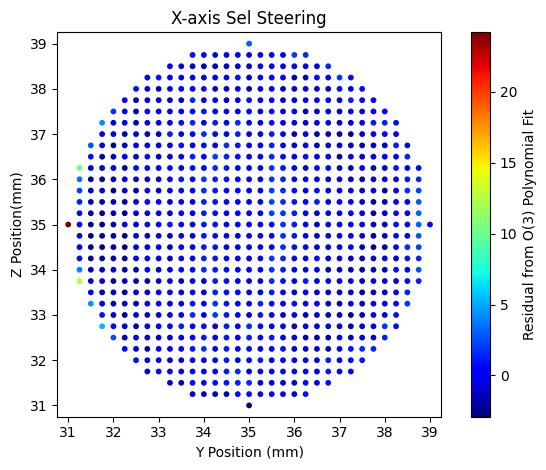

In [8]:
# plot the residuals in 2d
plt.figure('BestSelXSteering')
plt.scatter(ypos,zpos,c=xsteer_result.residual, s=10, cmap='jet')
plt.xlabel('Y Position (mm)')
plt.ylabel('Z Position(mm)')
plt.xlim(min(ypos)-p_step, max(ypos)+p_step)
plt.ylim(min(zpos)-p_step, max(zpos)+p_step)
plt.colorbar(label="Residual from O("+str(order)+") Polynomial Fit")
plt.title('X-axis Sel Steering')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('SEL_X_Steering_Fit_Plot_Residual.png')
print('Mean Residual:',np.mean(np.abs(xsteer_result.residual)))
print('Max Residual:',np.amax(np.abs(xsteer_result.residual)))
print('Std Residual:',np.std(np.abs(xsteer_result.residual)))

In [9]:
zsteer_result = model.fit(vsteerz, y=ypos, z=zpos, params=params)
zsteer_file = open('SEL_Z_Steering_EquationParameters.csv', 'w', encoding="utf-8")
zsteer_file.write(zsteer_result.fit_report(show_correl=False))
zsteer_file.write('\n[[Model Equation]]\n\u03A3_i\u03A3_j c_i,j * ypos^i * zpos^j')
zsteer_file.close()
print(zsteer_result.params.pretty_print(columns=['value', 'stderr']))

Name     Value   Stderr
c00  4.575e+06 4.652e+06
c01  -3.942e+05 3.993e+05
c02  1.13e+04 1.142e+04
c03    -107.7    108.7
c10  -4.019e+05 3.993e+05
c11  3.458e+04 3.428e+04
c12    -990.4    979.9
c13     9.444    9.331
c20  1.171e+04 1.142e+04
c21     -1006      980
c22     28.81    28.02
c23   -0.2748   0.2668
c30    -113.8    108.7
c31     9.767    9.332
c32   -0.2795   0.2668
c33  0.002666  0.00254
None


In [18]:
%matplotlib notebook

# Generate meshgrid for plotting
num_points = 1000
y_range = np.linspace(min(ypos), max(ypos), num_points)
z_range = np.linspace(min(zpos), max(zpos), num_points)
Y, Z = np.meshgrid(y_range, z_range)
VZ = xsteer_result.eval(params=zsteer_result.params, y=Y, z=Z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ypos, zpos, vsteerz, c='red', label='Data')
ax.plot_surface(Y, Z, VZ, cmap='jet', alpha=0.5, label='Fitted Surface')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Voltage')
plt.tight_layout()
plt.savefig('SEL_Z_Steering_Fit_Plot.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ypos, zpos, vsteerz, c='red', label='Data')
ax.plot_surface(Y, Z, VZ, cmap='jet', alpha=0.5, label='Fitted Surface')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Voltage')
ax.view_init(0,0)

Mean Residual: 1.666538660051851
Max Residual: 20.638031122118264
Std Residual: 1.7633208490354808


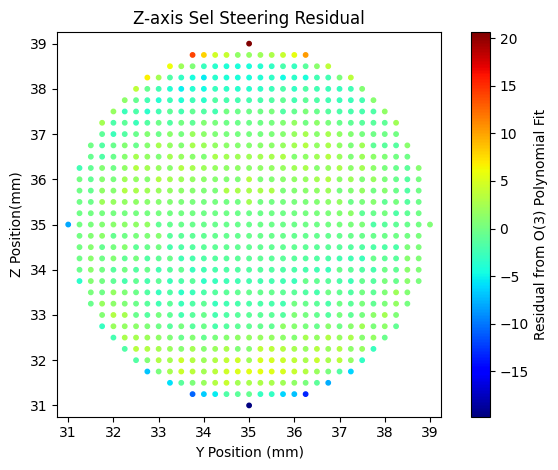

In [11]:
# plot the residuals in 2d
plt.figure('BestSelZSteering')
plt.scatter(ypos,zpos,c=zsteer_result.residual, s=10, cmap='jet')
plt.xlabel('Y Position (mm)')
plt.ylabel('Z Position(mm)')
plt.xlim(min(ypos)-p_step, max(ypos)+p_step)
plt.ylim(min(zpos)-p_step, max(zpos)+p_step)
plt.colorbar(label="Residual from O("+str(order)+") Polynomial Fit")
plt.title('Z-axis Sel Steering Residual')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('SEL_Z_Steering_Fit_Plot_Residual.png')
print('Mean Residual:',np.mean(np.abs(zsteer_result.residual)))
print('Max Residual:',np.amax(np.abs(zsteer_result.residual)))
print('Std Residual:',np.std(np.abs(zsteer_result.residual)))